In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [19]:
import seaborn as sns
sns.set(style = 'whitegrid')

In [79]:
col_name = ['Segment','gamecategory','subgamecategory','bundle','created','shift','city', 'os','osv']#'oblast',
X_train = pd.read_csv('hackaton_train.csv.zip', sep=',', parse_dates=['created'])[col_name] #, nrows=1000

In [80]:
#удалим все строки с пропусками, чтобы не мешали строить графики
X_train.dropna(inplace=True)

In [91]:
#добавим параметры дня недели и часа
replace_msk = {'MSK': 0, 'MSK+1': 1, 'MSK+2': 2, 'MSK+3': 3, 'MSK+4': 4, 'MSK+5': 5, 'MSK+6': 6, 
               'MSK+7': 7, 'MSK+8': 8, 'MSK+9': 9, 'MSK-1': -1}
#замена сдига времени на точное число
X_train['shift'] = X_train['shift'].replace(replace_msk).fillna(0).astype("int8")
X_train['local_created'] = X_train['created'] + pd.to_timedelta(X_train['shift'],'h')
#Час и день недели создания файла
X_train['hour_created'] = X_train['local_created'].dt.hour
#понедельник 0
X_train['day_created'] = X_train['local_created'].dt.dayofweek

In [81]:
X_train.head()

,Segment,gamecategory,subgamecategory,bundle,created,shift,city,os,osv
0,4,Games,Racing,com.MadOut.BIG,2021-07-05 18:07:40,MSK+6,Чита,android,10.0
2,5,Games,Arcade,com.orbitalknight.ridiculousfreekick,2021-08-04 13:34:29,MSK,Санкт-Петербург,android,9.0
5,5,Games,Puzzle,com.hwg.sos,2021-09-18 09:44:24,MSK,Альметьевск,android,7.1
6,4,Games,Arcade,com.hikergames.ArcadeHunter,2021-08-02 08:52:24,MSK,Москва,android,11.0
7,5,Games,Card,com.lemongame.klondike.solitaire,2021-09-18 02:36:11,MSK,Санкт-Петербург,android,8.1.0


## Анализ существующих сегменов

In [127]:
segment = pd.read_excel('Segments.xlsx', index_col='Номер сегмента')
segment["Охват, %"] = [2.0, 3.1, 31.6, 24.8, 38.3]
segment["Кластеры"] = ["4,1", "0,1", "4,1", "4,5", "5,6"]
segment[["Охват, %", "Возраст", "Пол", "Интересы", "Кластеры"]]

,"Охват, %",Возраст,Пол,Интересы,Кластеры
Номер сегмента,,,,,
1,2.0,"25-34,35-41",Ж,-,"4,1"
2,3.1,"25-34,35-42",М,Пиво,"0,1"
3,31.6,"25-34,35-43",Ж,Дети,"4,1"
4,24.8,"18-24,25-34,35-44","М, Ж",Животные,"4,5"
5,38.3,"18-24,25-34,35-45","М, Ж",-,"5,6"


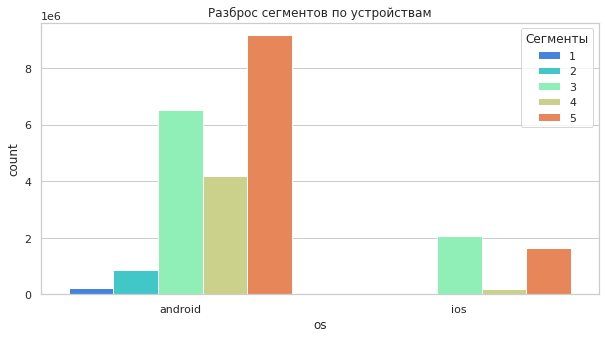

In [84]:
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(x="os", hue="Segment", data=X_train, palette="rainbow")
plt.legend(loc = 'upper right', title = "Сегменты")
plt.title("Разброс сегментов по устройствам")
plt.show()

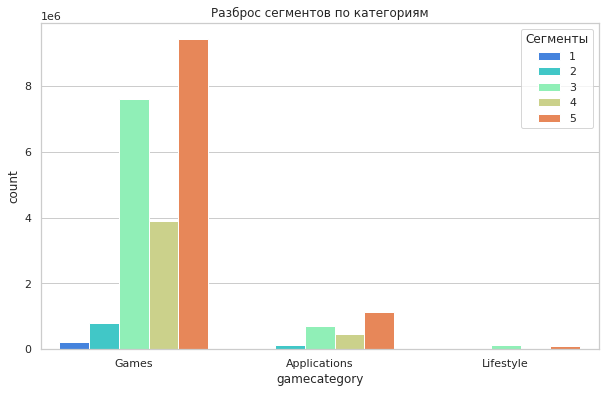

In [85]:
fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(x="gamecategory", hue="Segment", data=X_train, palette="rainbow",
              order=X_train.gamecategory.value_counts().iloc[:3].index)
plt.legend(loc = 'upper right', title = "Сегменты")
plt.title("Разброс сегментов по категориям")
plt.show()

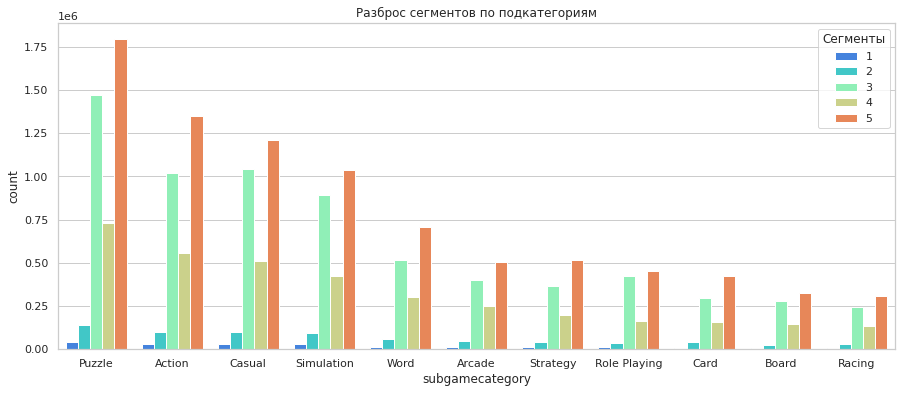

In [86]:
fig, ax = plt.subplots(figsize=(15,6))
sns.countplot(x="subgamecategory", hue="Segment", data=X_train, palette="rainbow", 
              order=X_train.subgamecategory.value_counts().iloc[:11].index)
plt.legend(loc = 'upper right', title = "Сегменты")
plt.title("Разброс сегментов по подкатегориям")
plt.show()

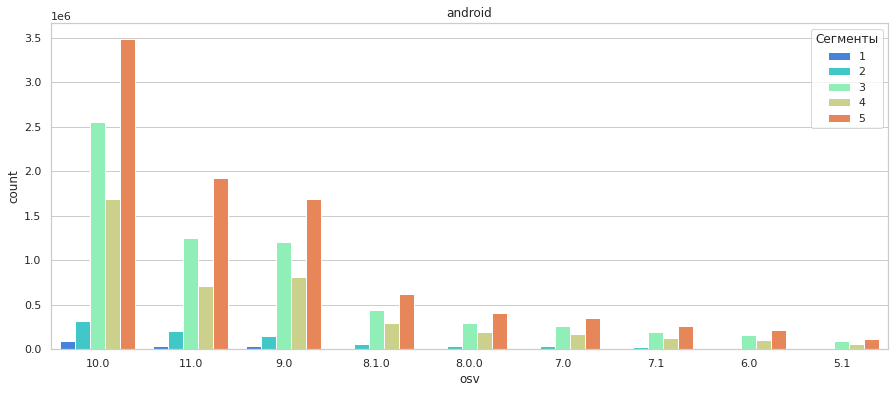

In [87]:
fig, ax = plt.subplots(figsize=(15,6))
sns.countplot(x="osv", hue="Segment", data=X_train[X_train.os =='android'], palette="rainbow", 
              order=X_train[X_train.os =='android'].osv.value_counts().iloc[:9].index)
plt.legend(loc = 'upper right', title = "Сегменты")
plt.title("android")
plt.show()

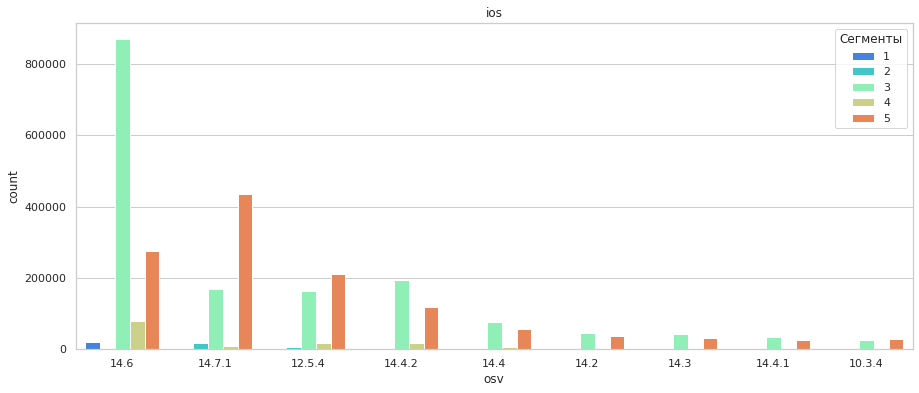

In [88]:
fig, ax = plt.subplots(figsize=(15,6))
sns.countplot(x="osv", hue="Segment", data=X_train[X_train.os =='ios'], palette="rainbow", 
              order=X_train[X_train.os =='ios'].osv.value_counts().iloc[:9].index)
plt.legend(loc = 'upper right', title = "Сегменты")
plt.title("ios")
plt.show()

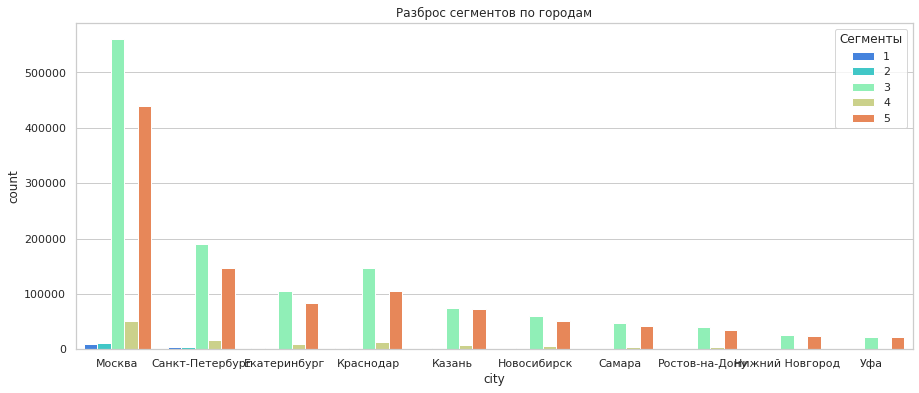

In [89]:
fig, ax = plt.subplots(figsize=(15,6))
sns.countplot(x="city", hue="Segment", data=X_train[X_train.os =='ios'], palette="rainbow", 
              order=X_train.city.value_counts().iloc[0:10].index)
plt.legend(loc = 'upper right', title = "Сегменты")
plt.title("Разброс сегментов по городам")
plt.show()

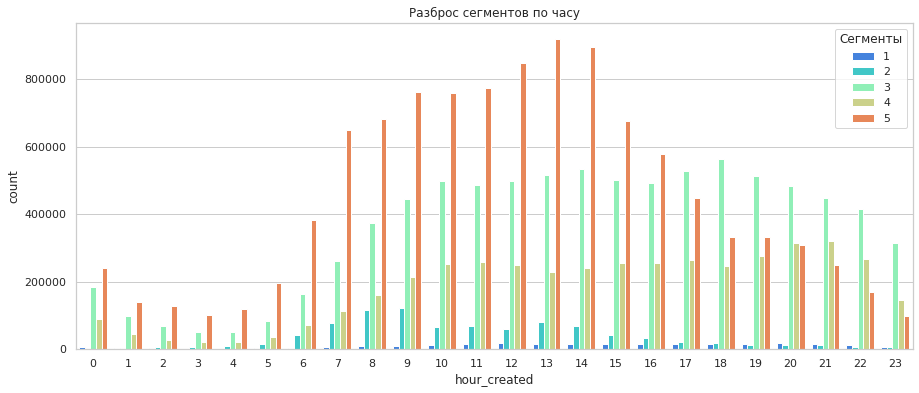

In [95]:
fig, ax = plt.subplots(figsize=(15,6))
sns.countplot(x="hour_created", hue="Segment", data=X_train, palette="rainbow",)
plt.legend(loc = 'upper right', title = "Сегменты")
plt.title("Разброс сегментов по часу")
plt.show()

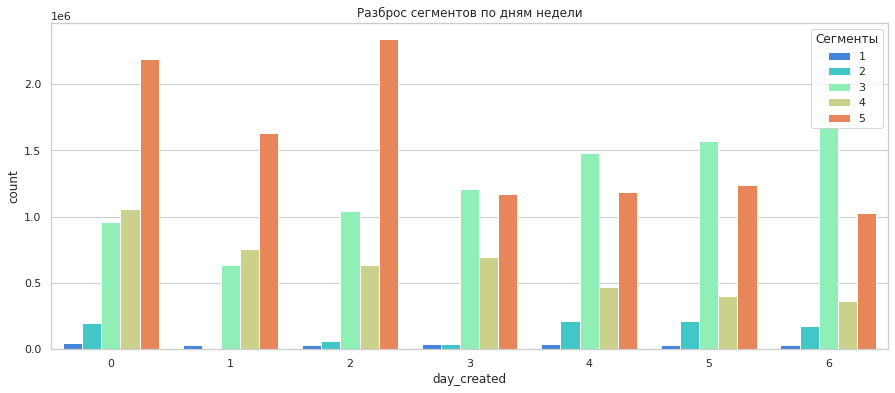

In [98]:
#0 понедельник
fig, ax = plt.subplots(figsize=(15,6))
sns.countplot(x="day_created", hue="Segment", data=X_train, palette="rainbow")
plt.legend(loc = 'upper right', title = "Сегменты")
plt.title("Разброс сегментов по дням недели")
plt.show()

### Выделение новых сегментов 
на основе поведения (время посещения)

In [120]:
temp = X_train[["hour_created", "day_created"]]

In [105]:
kmeans = KMeans(n_clusters=7, random_state=42).fit(temp)

In [121]:
k = kmeans.predict(temp)

In [123]:
temp['segment'] = X_train.Segment
temp['kmeans'] = k
temp.head()

,hour_created,day_created,segment,kmeans
0,0,1,4,3
2,13,2,5,5
5,9,5,5,0
6,8,0,4,6
7,2,5,5,3


In [113]:
temp[temp.segment==1].kmeans.value_counts(normalize=True, dropna=False)

4    0.223150
1    0.183809
5    0.175964
0    0.131401
2    0.123127
6    0.093465
3    0.069084
Name: kmeans, dtype: float64

In [114]:
temp[temp.segment==2].kmeans.value_counts(normalize=True, dropna=False)

0    0.394467
1    0.225875
6    0.182436
5    0.077849
4    0.052205
3    0.041207
2    0.025961
Name: kmeans, dtype: float64

In [115]:
temp[temp.segment==3].kmeans.value_counts(normalize=True, dropna=False)

4    0.227278
1    0.227009
0    0.188727
5    0.114440
2    0.092907
6    0.090921
3    0.058719
Name: kmeans, dtype: float64

In [116]:
temp[temp.segment==4].kmeans.value_counts(normalize=True, dropna=False)

4    0.244634
5    0.179979
2    0.166954
6    0.147094
1    0.126862
0    0.085682
3    0.048795
Name: kmeans, dtype: float64

In [117]:
temp[temp.segment==5].kmeans.value_counts(normalize=True, dropna=False)

5    0.292391
6    0.181161
0    0.170764
2    0.116319
4    0.083064
3    0.079493
1    0.076807
Name: kmeans, dtype: float64